In [184]:
# Boilerplate at top of file
# %load_ext autoreload
import rpy2
%load_ext rpy2.ipython
# %autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *



from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

import os

import seaborn as sns

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [185]:
data_dir = '../data/'

direcs = map(lambda x: data_dir + x,[
        'look_left_good/events',
        'look_left_bad/events',
        'look_right_good/events',
        'look_right_bad/events',
    ])
# flatten all event files into a single list of file paths
event_files = reduce(lambda l,r:l + r,
                     map(lambda x: 
                         map(lambda y: x + '/' + y, os.listdir(x)), 
                         direcs
                        )
                    )
# print event_files

# Example of the event data

In [186]:
event_files

['../data/look_left_good/events/1458443939-0.csv',
 '../data/look_left_good/events/1458443939-1.csv',
 '../data/look_left_good/events/1458443939-2.csv',
 '../data/look_left_good/events/1458444019-0.csv',
 '../data/look_left_good/events/1458444019-1.csv',
 '../data/look_left_good/events/1458444019-2.csv',
 '../data/look_left_good/events/1458444019-3.csv',
 '../data/look_left_good/events/1458444019-4.csv',
 '../data/look_left_good/events/1458444019-5.csv',
 '../data/look_left_good/events/1458446196-0.csv',
 '../data/look_left_good/events/1458446196-1.csv',
 '../data/look_left_good/events/1458446196-2.csv',
 '../data/look_left_good/events/1458446196-3.csv',
 '../data/look_left_good/events/1458446196-4.csv',
 '../data/look_left_good/events/1458446244-0.csv',
 '../data/look_left_good/events/1458446244-1.csv',
 '../data/look_left_good/events/1458446244-2.csv',
 '../data/look_left_good/events/1458446244-3.csv',
 '../data/look_left_good/events/1458446276-0.csv',
 '../data/look_left_good/events

In [201]:
(a[0].time - a[0].shift(periods=1).time

AttributeError: 'int' object has no attribute 'time'

In [203]:
df_a

,delta_x,delta_y,front_face_count,signal_length,slowSpeedCount,good_turn
0,0.151345,0.068538,0.444444,0.53,3,True
1,0.194838,0.054145,0.384615,0.85,3,True
2,0.184477,0.051659,0.400000,0.65,4,True
3,0.308515,0.039581,0.444444,0.66,1,True
4,0.482551,0.098297,0.818182,0.74,5,True
5,0.239090,0.070496,0.250000,0.79,5,True
6,0.134041,0.059665,0.333333,0.74,5,True
7,0.243316,0.050317,0.230769,0.87,5,True
8,0.209654,0.038499,0.153846,0.83,4,True
9,0.229661,0.084602,0.400000,0.95,5,True


(array([ 57.,  18.,   2.,   2.,   0.,   1.,   1.,   0.,   0.,   1.]),
 array([  0. ,   3.1,   6.2,   9.3,  12.4,  15.5,  18.6,  21.7,  24.8,
         27.9,  31. ]),
 <a list of 10 Patch objects>)

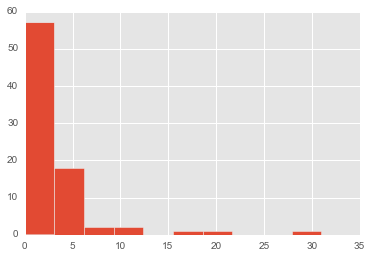

In [204]:
a = []
for f in event_files:


    df_a= pd.read_csv(f)
    a.append(len(df_a[df_a['faceBottom'] - df_a['faceTop'] != 0]))
plt.hist(a)

In [211]:
(df_a.time - df_a.shift(periods=1).time)[1:len(df_a)].mean()

0.069679486445891545


# Feature Engineering and Exploratory

In [229]:
def generate_signal_features(df, f):
    sampling_rate = (df['time'].max() - df['time'].min()) / len(df)
    df_box = df[df['isFrontFace'] != 0]
    # find the "average" box on the face in the signal
    average_bottom = df_box['faceBottom'].mean()
    average_top = df_box['faceTop'].mean()
    average_left = df_box['faceLeft'].mean()
    average_right = df_box['faceRight'].mean()
    x_dist = df['noseX'].max() - df['noseX'].min(0)
    y_dist = df['noseY'].max() - df['noseY'].min(0)
    speed_norm = df.apply(
        lambda x: np.linalg.norm([x['noseX_1_steps'], x['noseY_1_steps']]), 
        axis=1,
        )
    data_points = float(len(df))
    row=dict()
    row['signal_length'] = df['time'].max() - df['time'].min()
#     row['noseX_delta_max'] = df['noseX'].max() - df['noseX'].min(0)
    row['delta_x'] = abs(x_dist / (average_right - average_left))
    row['delta_y'] = abs(y_dist / (average_top - average_bottom))

#     row['front_face_count'] = sum(df['isFrontFace'] == 1) / data_points

#     row['slowSpeedCount'] = sum(speed_norm < 1) / data_points

    row['good_turn'] = str(df['turn_sentiment'].max().find('good') != -1)
    row['file_name'] = f
    return row

def feature_diagnostics(df, f):
    pass

In [232]:
events = []
for f in event_files:
    row = generate_signal_features(pd.read_csv(f), f)
    events.append(row)
df_events = pd.DataFrame(events).fillna(0)
#class_col = 'turn_sentiment'
class_col = 'good_turn'
Y = LabelEncoder().fit_transform(df_events[class_col])

active_features = df_events._get_numeric_data().columns.tolist()
df_num = df_events[active_features]
df_a = df_events[active_features + [class_col]]
print active_features

['delta_x', 'delta_y', 'signal_length']


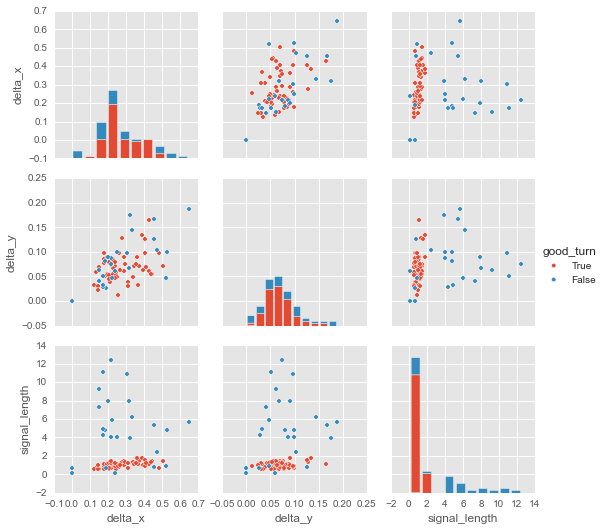

In [233]:

sns.pairplot(df_a, hue="good_turn")

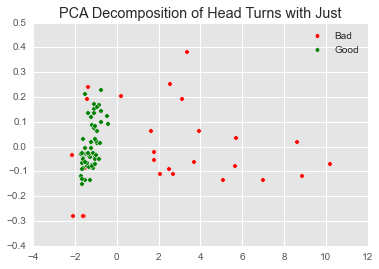

In [234]:
pca = PCA(n_components=2)
X = pca.fit_transform(df_events[active_features])
plt.scatter(X[Y==0,0], X[Y==0,1], c = 'red', label='Bad')
plt.scatter(X[Y==1,0], X[Y==1,1], c = 'green', label='Good')
plt.title("PCA Decomposition of Head Turns with Just ")
plt.legend()
# red is good head turns
# blue is bad behavior

# Classifier

In [193]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score


In [194]:
def train_split_classify(df, active_features, y_feature, clf, k = 10):
    X = df[active_features]
    Y = LabelEncoder().fit_transform(df[y_feature])
    accuracies = []
    recalls = []
    precisions = []
    cof_mat = []
    print '\n======\n'
    print 'Cross validating for', clf.__class__

    for i in xrange(k):
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.3, random_state=42
        )
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        cof_mat.append(confusion_matrix(Y_pred, Y_test))
        accuracies.append(accuracy_score(Y_pred, Y_test))
        recalls.append(recall_score(Y_pred, Y_test))
        precisions.append(precision_score(Y_pred, Y_test))
        
    print 'Confusion Matrix:', sum(cof_mat)
    print 'Accuracy:', np.mean(accuracies)
    print 'Recall:', np.mean(recalls)
    print 'Precision:', np.mean(precisions)
    

In [195]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier()
svm = SVC()
glm = LogisticRegression()
dt = DecisionTreeClassifier()

train_split_classify(df_events, active_features, class_col, rf)
train_split_classify(df_events, active_features, class_col, svm)
train_split_classify(df_events, active_features, class_col, glm)
train_split_classify(df_events, active_features, class_col, dt)



Cross validating for <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Confusion Matrix: [[ 59   4]
 [  1 186]]
Accuracy: 0.98
Recall: 0.995
Precision: 0.978947368421


Cross validating for <class 'sklearn.svm.classes.SVC'>
Confusion Matrix: [[ 50   0]
 [ 10 190]]
Accuracy: 0.96
Recall: 0.95
Precision: 1.0


Cross validating for <class 'sklearn.linear_model.logistic.LogisticRegression'>
Confusion Matrix: [[ 40   0]
 [ 20 190]]
Accuracy: 0.92
Recall: 0.904761904762
Precision: 1.0


Cross validating for <class 'sklearn.tree.tree.DecisionTreeClassifier'>
Confusion Matrix: [[ 50  20]
 [ 10 170]]
Accuracy: 0.88
Recall: 0.944444444444
Precision: 0.894736842105
